In [160]:
import pandas as pd
import datetime as dt

def conv_str_to_time(time_str):
    time = dt.datetime.strptime(time_str, '%Y.%m.%d %H:%M:%S.%f')
    return time

#Reading the data
df = pd.read_csv('17_04_NT_deals.csv', delimiter=';', index_col='Timestamp')
column_to_del = []

#Filter the data
for column in df.columns:
    if (column != 'Counterparty' and column != 'B/S' and column !='Instrument' and \
        column !='Tenor' and column != 'Price' and column != 'Amount' and \
        column !='Counterparty Trader' and column != 'Initiator Id' and \
        column != 'Initiator' and column != 'Timestamp'):
            column_to_del.append(column)

df = df.drop(columns=column_to_del, axis=1)    

df = df[df['Instrument'] == 'USDRUB']
df = df[df['Tenor'] == 'TOM']
df = df[df['Counterparty'] != 'ALFN']

df.reset_index(inplace=True)

#change B/S to 1/-1
dict_b_s = {'Buy': 1, 'Sell': -1}
df['B/S'] = df['B/S'].map(dict_b_s)

#Creating Volume*Side B/S
df['Amount_b/s'] = df['B/S']*df['Amount']

#Deleting LPs (need only external trades)
i=0
index_to_del = []
for i in range(df.shape[0]):
    counterparty = df['Counterparty Trader'].iloc[i]
    if counterparty.endswith('LP'):
        index_to_del.append(i)

df = df.drop(labels=index_to_del, axis=0)
df.sort_values(by='Timestamp', axis=0, ascending=True, inplace=True)

# Particular client's under investigation trades
client_trades = df[df['Counterparty'] == 'IMBX']

#Other external trades
ext_trades = df[df['Counterparty'] != 'IMBX']

In [161]:

time_of_ext_trades = []
volumes_ext =[]
time_and_vol_ext = []

time_of_client_trades = []
volumes_client = []
time_and_vol_client = []

#going through Clients's trades to analyze
#for each trade time we build range t0, t0+600 sec 
#within this range we build volumes
#client_trades.shape[0]
for j in range(client_trades.shape[0]):
    time_0 = conv_str_to_time(client_trades['Timestamp'].iloc[j])
    delta = dt.timedelta(seconds=600)
    time_1 = time_0 + delta

    time_str_0 = time_0.strftime('%Y.%m.%d %H:%M:%S')
    time_str_1 = time_1.strftime('%Y.%m.%d %H:%M:%S')
    
    #selecting trades in time range [t0, t0+600 sec]
    client_select = client_trades[client_trades['Timestamp'] >= time_str_0]
    client_select = client_select[client_select['Timestamp'] <= time_str_1]
    ext_select = ext_trades[ext_trades['Timestamp'] >= time_str_0]
    ext_select = ext_select[ext_select['Timestamp'] <= time_str_1]
    
    for i in range(ext_select.shape[0]):
        time_delta = (conv_str_to_time(ext_select['Timestamp'].iloc[i]) - time_0).total_seconds()
        time_of_ext_trades.append(int(time_delta))
        volumes_ext.append(ext_select['Amount_b/s'].iloc[i])
        
    time_and_vol_ext.append((time_of_ext_trades, volumes_ext))
    time_of_ext_trades = []
    volumes_ext = []

    for i in range(client_select.shape[0]):
        time_delta = (conv_str_to_time(client_select['Timestamp'].iloc[i]) - time_0).total_seconds()
        time_of_client_trades.append(int(time_delta))
        volumes_client.append(client_select['Amount_b/s'].iloc[i])
        
    time_and_vol_client.append((time_of_client_trades, volumes_client))
    time_of_client_trades = []
    volumes_client = []
    
    #exclude selected trades (not to duplicate in next step of calculation)
    ext_trades = ext_trades[~ext_trades['Timestamp'].isin(ext_select)]
    client_trades = client_trades[~client_trades['Timestamp'].isin(client_select)]

In [171]:
volume = -5000000
volume_total = []
time_delta = time_and_vol_ext[0][0]
for vol in time_and_vol_ext[0][1]:
    volume = volume +vol
    volume_total.append(round(volume, 2))
    
print(volume_total)

[-6000000.0, -7000000.0, -7500000.0, -7000000.0, -6500000.0, -5500000.0, -6352892.0, -6852892.0, -7352892.0, -8352892.0, -8402892.0, -7402892.0, -6402892.0, -5902892.0, -5908892.0, -4908892.0, 91108.0, -360892.0, -410892.0, -550892.0, -950892.0, -1450755.0, -1950755.0, -1962755.0, -1983755.0, -2483755.0, -2550755.0, -5556755.0, -5506755.0, -6506755.0, -6206755.0, -6006755.0, -7006755.0, -6606755.0, -6106755.0, -6606755.0, -6656755.0, -6156755.0, 3843245.0, 3718245.0, 3218245.0, 2218300.0, 1718300.0, 718300.0, 218300.0, 368300.0, 1368300.0, 1168300.0, 668300.0, 168300.0, -131700.0, -231700.0, 768300.0, -2231700.0, -1731700.0, -2731700.0, -1731700.0, -1231700.0, -731700.0, -231700.0, 18300.0, 1018300.0, 518300.0, -481700.0, -1481700.0, -481700.0, -5481700.0, -6481700.0, -7481700.0, -8481700.0, -8384700.0, -7884700.0, -7715830.0, -7215830.0, -6715830.0, -6215830.0, -5215830.0, -5715830.0, -5865762.0, -6365762.0, -6865762.0, -7365762.0, -7865762.0, -8365762.0, -8865762.0, -9365762.0, -8865

In [170]:
print(time_and_vol_ext[0][0])

[0, 26, 50, 51, 51, 75, 79, 79, 79, 79, 88, 89, 97, 102, 105, 116, 119, 120, 120, 123, 127, 130, 130, 140, 140, 140, 146, 149, 150, 154, 156, 156, 162, 170, 170, 178, 186, 189, 206, 212, 212, 216, 216, 216, 218, 218, 218, 220, 229, 229, 233, 246, 249, 254, 255, 256, 256, 256, 256, 256, 260, 260, 261, 261, 264, 266, 267, 267, 268, 268, 274, 275, 282, 283, 283, 284, 286, 288, 288, 313, 313, 318, 325, 325, 328, 328, 332, 334, 337, 343, 346, 347, 347, 348, 365, 383, 385, 399, 401, 418, 418, 430, 434, 452, 457, 459, 468, 472, 472, 497, 497, 504, 504, 511, 545, 561, 561, 582, 591, 591, 591, 598, 598]


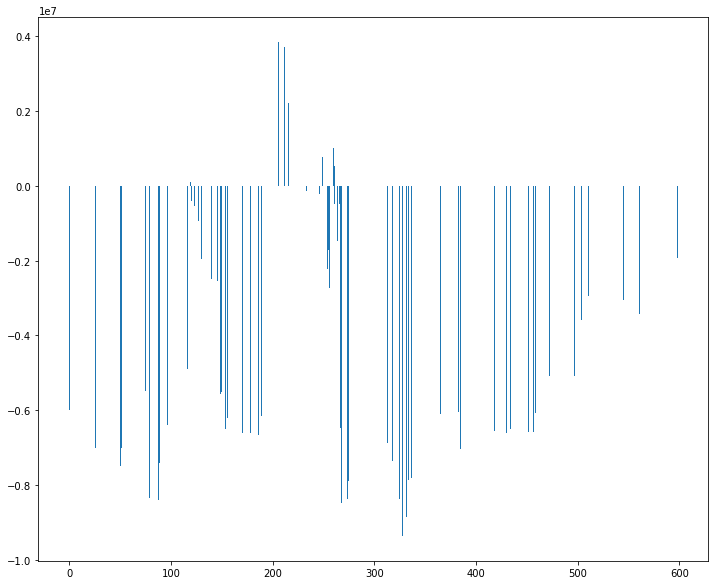

In [175]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(12, 10))
plt.bar(time_delta, volume_total)
plt.show()

In [140]:
print(time_and_vol_ext[1][0] + print(time_and_vol_ext[0][0]))

[0.0, 26.0, 51.0, 52.0, 52.0, 76.0, 80.0, 80.0, 80.0, 80.0, 89.0, 90.0, 98.0, 103.0, 105.0, 117.0, 120.0, 120.0, 121.0, 124.0, 127.0, 130.0, 130.0, 140.0, 140.0, 141.0, 146.0, 149.0, 150.0, 155.0, 157.0, 157.0, 162.0, 170.0, 170.0, 179.0, 187.0, 189.0, 206.0, 212.0, 212.0, 216.0, 216.0, 216.0, 218.0, 219.0, 219.0, 221.0, 230.0, 230.0, 234.0, 247.0, 250.0, 254.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 260.0, 260.0, 261.0, 262.0, 264.0, 267.0, 268.0, 268.0, 268.0, 269.0, 275.0, 276.0, 282.0, 284.0, 284.0, 285.0, 286.0, 288.0, 288.0, 313.0, 313.0, 319.0, 326.0, 326.0, 329.0, 329.0, 332.0, 334.0, 337.0, 343.0, 346.0, 347.0, 348.0, 348.0, 365.0, 383.0, 386.0, 400.0, 402.0, 418.0, 418.0, 430.0, 435.0, 452.0, 458.0, 460.0, 469.0, 473.0, 473.0, 498.0, 498.0, 505.0, 505.0, 512.0, 545.0, 562.0, 562.0, 582.0, 592.0, 592.0, 592.0, 598.0, 598.0]


TypeError: can only concatenate list (not "NoneType") to list

In [35]:
print(imbx_trades)

                    Timestamp Counterparty   B/S Instrument Tenor    Price  \
150   2019.04.17 10:10:45.862         IMBX  Sell     USDRUB   TOM  63.9582   
385   2019.04.17 11:32:25.446         IMBX  Sell     USDRUB   TOM  63.8774   
394   2019.04.17 11:38:21.738         IMBX  Sell     USDRUB   TOM  63.9145   
1991  2019.04.17 13:18:07.916         IMBX   Buy     USDRUB   TOM  63.9314   
1421  2019.04.17 17:45:05.197         IMBX  Sell     USDRUB   TOM  63.9057   

          Amount Counterparty Trader  Initiator Id Initiator  
150    5000000.0               IMBX3          4181     IMBX3  
385    5000000.0               IMBX3          4181     IMBX3  
394   10000000.0               IBMX2          1729     IBMX2  
1991  10000000.0               IMBX3          4181     IMBX3  
1421  20000000.0               IBMX2          1729     IBMX2  


In [44]:
ext_trades[~ext_trades['Timestamp'].isin(ext_select)]

count     -2556
unique       -2
top          -1
freq      -2556
Name: Timestamp, dtype: object

In [41]:
ext_select['Timestamp']

151     2019.04.17 10:10:46.348
152     2019.04.17 10:11:11.894
153     2019.04.17 10:11:36.555
1526    2019.04.17 10:11:37.850
1527    2019.04.17 10:11:37.850
1528    2019.04.17 10:12:01.466
154     2019.04.17 10:12:05.421
155     2019.04.17 10:12:05.425
156     2019.04.17 10:12:05.472
157     2019.04.17 10:12:05.660
158     2019.04.17 10:12:14.483
1529    2019.04.17 10:12:15.448
1530    2019.04.17 10:12:23.435
1531    2019.04.17 10:12:28.734
159     2019.04.17 10:12:30.968
1532    2019.04.17 10:12:42.558
1533    2019.04.17 10:12:45.718
161     2019.04.17 10:12:45.926
162     2019.04.17 10:12:46.600
163     2019.04.17 10:12:49.421
164     2019.04.17 10:12:53.099
166     2019.04.17 10:12:56.199
165     2019.04.17 10:12:56.199
167     2019.04.17 10:13:06.108
168     2019.04.17 10:13:06.221
169     2019.04.17 10:13:06.685
170     2019.04.17 10:13:12.158
171     2019.04.17 10:13:14.948
1534    2019.04.17 10:13:16.309
172     2019.04.17 10:13:20.650
                 ...           
1566    

In [54]:
print(df)

                    Timestamp Counterparty  B/S Instrument Tenor      Price  \
0     2019.04.17 02:37:20.828         ASAN   -1     USDRUB   TOM  64.100000   
1     2019.04.17 02:52:41.301         RZBM   -1     USDRUB   TOM  64.100500   
1445  2019.04.17 04:10:31.691         OFCB    1     USDRUB   TOM  64.035900   
2     2019.04.17 04:38:08.137         ASAN   -1     USDRUB   TOM  64.100500   
3     2019.04.17 05:06:36.963         ASAN   -1     USDRUB   TOM  64.100500   
4     2019.04.17 05:11:47.545         PRMC   -1     USDRUB   TOM  64.050500   
1446  2019.04.17 05:46:14.520         ALFA    1     USDRUB   TOM  64.035900   
1447  2019.04.17 05:46:18.432         ALFA    1     USDRUB   TOM  64.035900   
5     2019.04.17 05:50:48.789         ASAN   -1     USDRUB   TOM  64.100000   
1448  2019.04.17 06:23:26.735         OFCB    1     USDRUB   TOM  64.064100   
6     2019.04.17 06:35:47.957         TCBM   -1     USDRUB   TOM  64.102000   
1449  2019.04.17 06:51:16.357         ALFA    1     